In [18]:
import matplotlib
import matplotlib.pyplot as plt
from cleaning import DataCleaner
from preparation import DataPrepare
from modelling import Model
import pandas as pd
import numpy as np
import pickle
import os
import shap
from shap import TreeExplainer

curr_dir = os.path.abspath('')

In [23]:
basedf = pd.read_csv(os.path.join(curr_dir, 'data', 'zomato.csv'))
rand_ind = np.random.randint(0, basedf.shape[0], 200)
newdf = basedf.iloc[rand_ind, :]
newdf.reset_index(drop=True, inplace=True)
newdf.to_csv(os.path.join(curr_dir, 'data', "test_set_2.csv"), index=False)

In [24]:
batch_name = 'test_2'

etl_pred = DataCleaner(curr_dir, 'test_set_2.csv')
etl_pred.treat_columns()
etl_pred.treat_rows()
etl_pred.treat_dtypes()
etl_pred.save_data(batch_name + "_cleaned.pkl")

prep = DataPrepare(curr_dir, batch_name + '_cleaned.pkl')
prep.get_binary_features()
prep.get_one_hot_features()
prep.treat_col_cuisines()
prep.save_data(batch_name + "_prepared.pkl")

pred_model = Model(curr_dir, 'predict')
pred_model.set_data(batch_name + '_prepared.pkl')
pred_model.load_model('train_1_model_lightgbm.pkl')
y_pred = pred_model.get_predictions()

--- Renamed, dropped columns : (200, 10)
--- Dropped appropriate rows : (197, 10)
Done treating dtypes : (197, 10)
before saving : (197, 10)
--- Saved data to local ---
Dealing with nan value
Dealing with nan value
Dealing with nan value
Dealing with nan value
--- Saved data to local ---
--- Model loaded ---


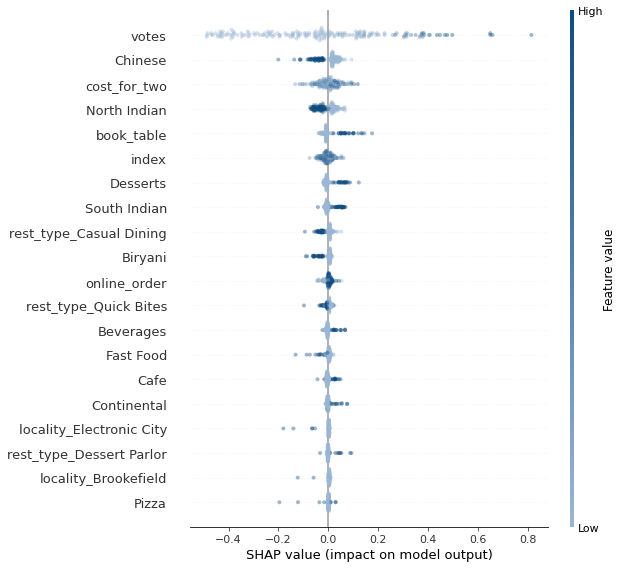

In [27]:
exp_model = pred_model.trained_model

explainer = TreeExplainer(exp_model)
shap_values = explainer.shap_values(pred_model.x.drop('record_id', axis=1))
colors = ["#9bb7d4", "#0f4c81"]           
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values, pred_model.x.drop('record_id', axis=1),cmap=cmap,alpha=0.4)

In [31]:
def explainer_1(col, interaction=None):
    explainer = TreeExplainer(exp_model)
    shap_values = explainer.shap_values(pred_model.x.drop('record_id', axis=1))
    shap.dependence_plot(col, shap_values, pred_model.x.drop('record_id', axis=1), interaction_index=interaction, show=False)
    plt.title("Dependence plot",loc='left',fontfamily='serif',fontsize=15)
    plt.ylabel("SHAP value for the 'Age' feature")
    plt.show()

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


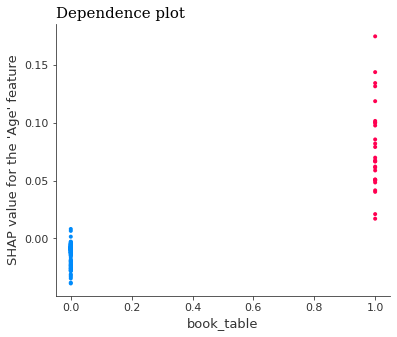

In [32]:
explainer_1('book_table', 'book_table')

<BarContainer object of 15 artists>

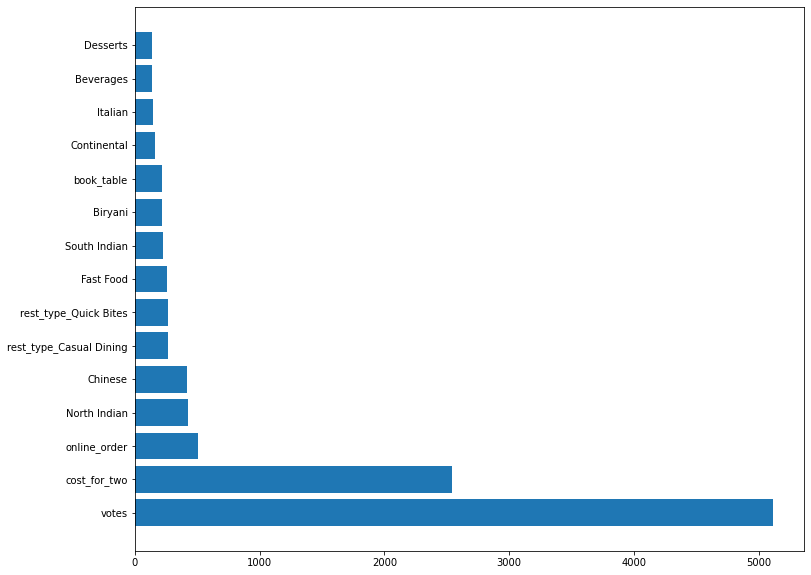

In [43]:
feats = pd.DataFrame({'col' : train_model.x.columns, 'imp' : exp_model.feature_importances_})
feats.sort_values('imp', ascending=False, inplace=True)
dfplt = feats.head(15)
plt.figure(figsize=(12, 10))
plt.barh(dfplt['col'], dfplt['imp'])

In [56]:
def explainer_3(pt, end_pt):
    explainer = TreeExplainer(exp_model)
    shap_values = explainer.shap_values(train_model.x.iloc[:end_pt, :])
    shap.force_plot(explainer.expected_value, shap_values[pt, :], train_model.x.iloc[pt, :])

In [57]:
explainer_3(50, 100)